In [69]:
#libraries and stuff
%pip install rasterio matplotlib numpy pandas geopandas contextily scikit-learn tensorflow seaborn plotly

import rasterio # pyright: ignore[reportMissingImports]
import matplotlib.pyplot as plt # pyright: ignore[reportMissingModuleSource]
import matplotlib.colors as mcolors
import numpy as np # pyright: ignore[reportMissingImports]
import pandas as pd # pyright: ignore[reportMissingModuleSource]
from pyproj import Transformer # pyright: ignore[reportMissingImports]
import geopandas as gpd  # pyright: ignore[reportMissingModuleSource]
from shapely.geometry import Point # pyright: ignore[reportMissingModuleSource]
import contextily as ctx # pyright: ignore[reportMissingImports]
import sklearn  # pyright: ignore[reportMissingModuleSource]
from sklearn.model_selection import train_test_split # pyright: ignore[reportMissingModuleSource]
from sklearn.ensemble import RandomForestClassifier # pyright: ignore[reportMissingModuleSource]
from sklearn.metrics import classification_report # pyright: ignore[reportMissingModuleSource]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # pyright: ignore[reportMissingModuleSource]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # pyright: ignore[reportMissingModuleSource]
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential # pyright: ignore[reportMissingImports]
from tensorflow.keras.layers import Dense, Dropout # pyright: ignore[reportMissingImports]
from tensorflow.keras.utils import to_categorical # pyright: ignore[reportMissingImports]
import seaborn as sns # pyright: ignore[reportMissingModuleSource]
from datetime import datetime, timedelta
import plotly.graph_objects as go # pyright: ignore[reportMissingImports]
import plotly.express as px # pyright: ignore[reportMissingImports]

#path to vv 
tiff_path = "/data/S1A_IW_GRDH_1SDV_20250908T225857_20250908T225922_060903_0795C2_6042.SAFE/measurement/s1a-iw-grd-vv-20250908t225857-20250908t225922-060903-0795c2-001.tiff"

Note: you may need to restart the kernel to use updated packages.


In [28]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [9]:
#Opening the image
with rasterio.open(tiff_path) as src:
    img = src.read(1)

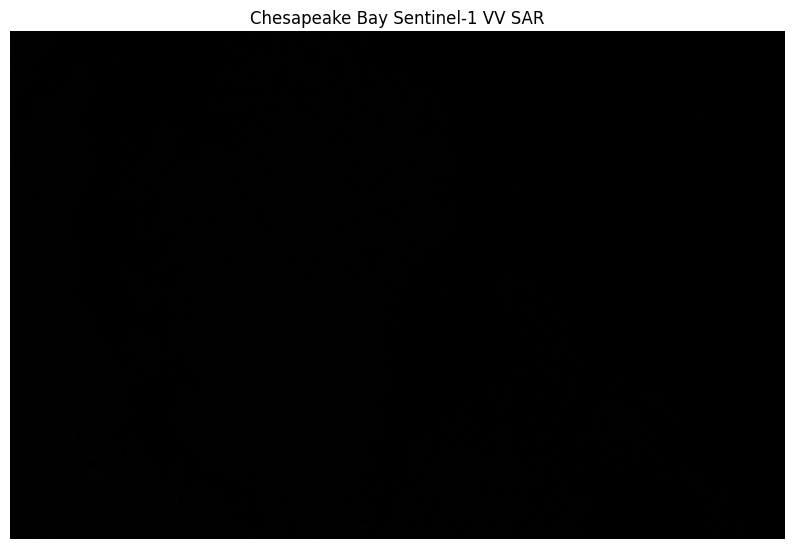

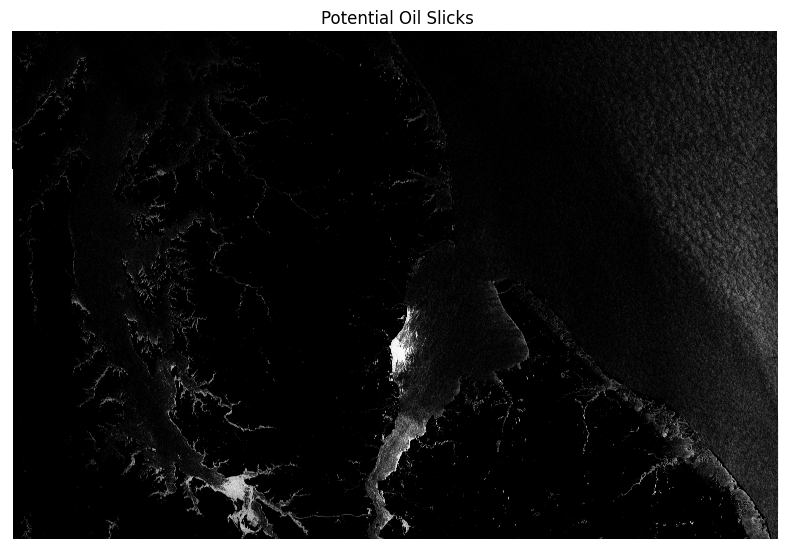

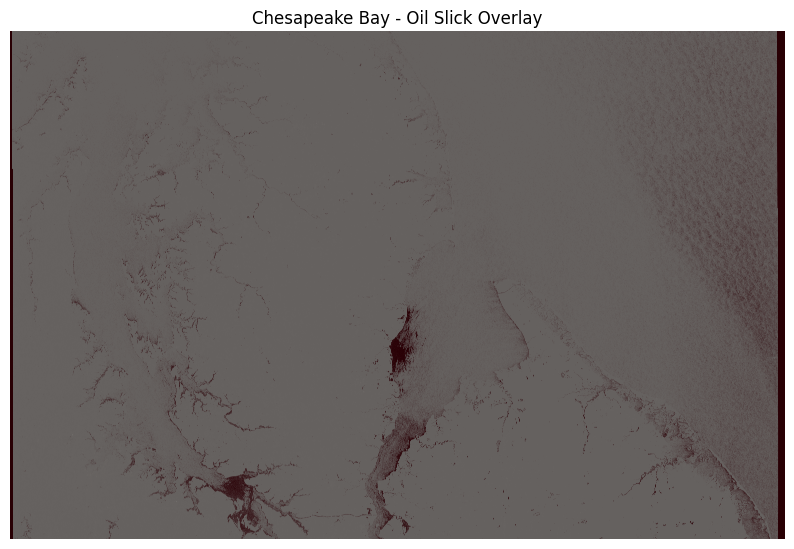

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.title("Chesapeake Bay Sentinel-1 VV SAR")
plt.axis('off')
plt.show()

# Dark areas indicate potential oil
threshold = np.percentile(img, 5)  # adjust 1-10% as needed
oil_mask = img < threshold

plt.figure(figsize=(10, 8))
plt.imshow(oil_mask, cmap='gray')
plt.title("Potential Oil Slicks")
plt.axis('off')
plt.show()

#Overlay mask on original SAR

plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.imshow(oil_mask, cmap='Reds', alpha=0.4)  # red overlay
plt.title("Chesapeake Bay - Oil Slick Overlay")
plt.axis('off')
#plt.imshow(img, cmap = 'gray', vmin = np.percentile(img, 1), vmax = np.percentile(img, 99))
plt.show()

In [ ]:
#NOTE: NO LONGER USE THIS FILE. ISSUE W/ DATA
# Now for putting the ship tracking data over the visualization

#loading it in
ship_df = pd.read_csv("data/AIS_2023_09_15.csv", low_memory = False)

In [17]:
#ship_df.head()
print(ship_df.columns)

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')


In [ ]:
#---PREPARING DATASET---#

lat_col = "LAT"
lon_col = "LON"

# Chesapeake Bay bounding box
lon_min, lon_max = -77.3, -75.0
lat_min, lat_max = 36.9, 39.8

# filter the DataFrame (no square brackets around the condition)
ship_subset = ship_df[
    (ship_df[lon_col] >= lon_min) & 
    (ship_df[lon_col] <= lon_max) & 
    (ship_df[lat_col] >= lat_min) & 
    (ship_df[lat_col] <= lat_max)
]

# number of ship points
print("Total points in the Baltimore/Chesapeake area:", len(ship_subset))

# save filtered CSV
ship_subset.to_csv("data/AIS_2023_09_15_Baltimore.csv", index=False)

Total points in the Baltimore/Chesapeake area: 432608


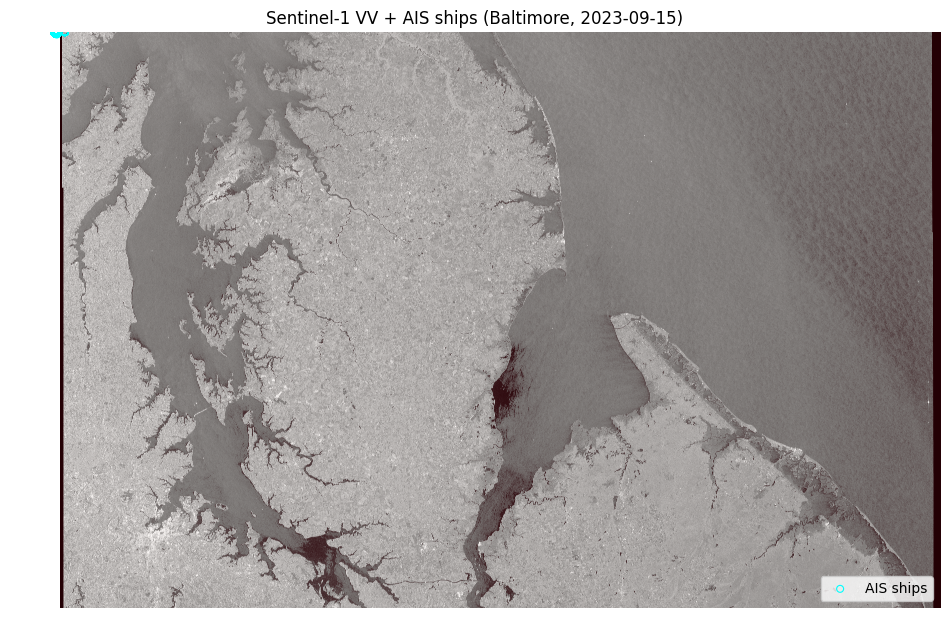

In [ ]:
#----SHIP TRACKING VISUAL ON TOP OF POTENTIAL OIL SLICKS VISUAL----#

#re-opening the SAR image
with rasterio.open(tiff_path) as src:
    img = src.read(1)
    transform = src.transform
    raster_crs = src.crs

#creating an oil mask for visualization
thresh = np.percentile(img[~np.isnan(img)], 5)
oil_mask = img < thresh

# --- Reproject AIS points if raster CRS is not EPSG:4326 ---
if raster_crs and raster_crs.to_string() != "EPSG:4326":
    transformer = Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True)
    xs, ys = transformer.transform(ship_df[lon_col].values, ship_df[lat_col].values)
else:
    xs, ys = ship_df[lon_col].values, ship_df[lat_col].values

# Convert to pixel coordinates
cols, rows = ~transform * (xs, ys)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(img, cmap='gray', vmin=np.percentile(img,1), vmax=np.percentile(img,99))
ax.imshow(oil_mask, cmap='Reds', alpha=0.35)
ax.scatter(cols, rows, s=25, edgecolors='cyan', facecolors='none', linewidth=0.8, label='AIS ships')
ax.legend(loc='lower right')
ax.set_title("Sentinel-1 VV + AIS ships (Baltimore, 2023-09-15)")
ax.axis('off')
plt.show()

In [4]:
#putting a pause on tracking the ships

#--- USING A DIFFERENT DATASET for OIL PREDICTIONS instead of SHIP TRACKING---#


df = pd.read_csv("/Users/lailahasan/Downloads/Chesapeake_SAR_Multi_Date_549_dates.csv")
# Chesapeake Bay bounding box from the original plot
lon_min, lon_max = -77.3, -75.0
lat_min, lat_max = 36.9, 39.8

chesapeake_df = df[
    (df['longitude'] >= -77.3) & (df['longitude'] <= -75.0) &
    (df['latitude'] >= 36.9) & (df['latitude'] <= 39.8)
]
print(len(chesapeake_df))

print("Number of points in Baltimore area:", len(chesapeake_df))

36840
Number of points in Baltimore area: 36840


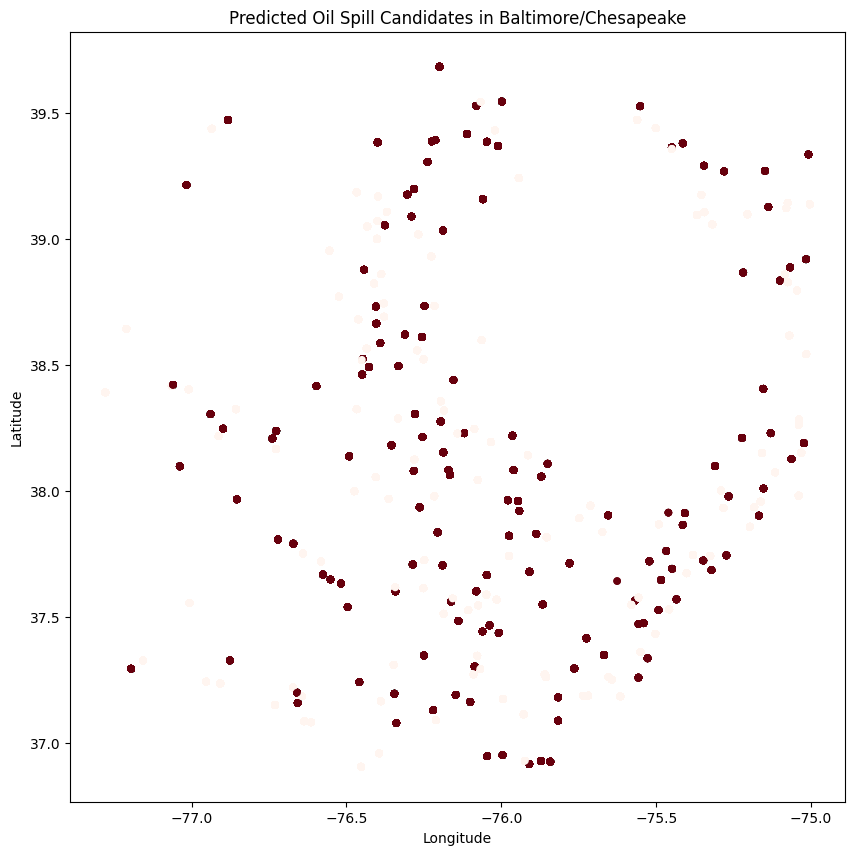

In [5]:
#-----PLOTTING THE PREDICTIONS-----#

plt.figure(figsize=(10,10))
plt.scatter(chesapeake_df['longitude'], chesapeake_df['latitude'],
            c=chesapeake_df['oil_candidate'], cmap='Reds', s=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted Oil Spill Candidates in Baltimore/Chesapeake")
plt.show()

In [6]:
#----- CLEANING THE DATASET ------#


# Keep only predicted oil spills
df_oil = chesapeake_df[chesapeake_df['oil_candidate'] == 1]

# Create a geometry column from longitude and latitude
geometry = [Point(xy) for xy in zip(df_oil['longitude'], df_oil['latitude'])]
gdf = gpd.GeoDataFrame(df_oil, geometry=geometry)

# Set CRS to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

system:index         VH  VH_VV_ratio         VV      angle        date  \
0            0_1_6 -26.646891     1.189828 -22.395576  40.176113  2015-03-10   
1           0_1_12 -27.743673     1.000304 -27.735235  44.549698  2015-03-10   
2           0_1_28 -28.506768     1.260118 -22.622309  43.564758  2015-03-10   
3           0_1_33 -55.104848     1.223977 -45.021158  45.592400  2015-03-10   
4           0_1_42 -26.189576     1.127723 -23.223421  44.446190  2015-03-10   
...            ...        ...          ...        ...        ...         ...   
37298    547_1_493 -28.783649     1.112254 -25.878670  40.225773  2025-09-25   
37305     548_1_41 -23.969084     0.869849 -27.555467  40.692215  2025-10-02   
37306    548_1_219 -32.673211     1.379422 -23.686160  35.613766  2025-10-02   
37307    548_1_313 -35.708206     1.547509 -23.074637  34.379524  2025-10-02   
37308    548_1_438 -33.675811     1.132253 -29.742290  33.390480  2025-10-02   

        latitude  longitude  oil_candidate  orbit_direction orbit_type  \
0      38.304327 -76.938988              1                0        ASC   
1      37.920340 -75.941974              1                0        ASC   
2      37.441714 -76.060847              1                0        ASC   
3      39.368536 -76.010592              1                0        ASC   
4      37.180730 -75.816590              1                0        ASC   
...          ...        ...            ...              ...        ...   
37298  37.966360 -76.853979              1                0        ASC   
37305  39.335186 -75.008256              1                0        ASC   
37306  37.902928 -75.654968              1                0        ASC   
37307  39.386964 -76.224448              1                0        ASC   
37308  39.383414 -76.399367              1                0        ASC   

                                                    .geo  \
0      {"type":"Point","coordinates":[-76.93898838099...   
1      {"type":"Point","coordinates":[-75.94197407529...   
2      {"type":"Point","coordinates":[-76.06084721612...   
3      {"type":"Point","coordinates":[-76.01059248597...   
4      {"type":"Point","coordinates":[-75.81658976546...   
...                                                  ...   
37298  {"type":"Point","coordinates":[-76.85397865643...   
37305  {"type":"Point","coordinates":[-75.00825585474...   
37306  {"type":"Point","coordinates":[-75.65496755189...   
37307  {"type":"Point","coordinates":[-76.22444844690...   
37308  {"type":"Point","coordinates":[-76.39936747439...   

                         geometry  
0      POINT (-76.93899 38.30433)  
1      POINT (-75.94197 37.92034)  
2      POINT (-76.06085 37.44171)  
3      POINT (-76.01059 39.36854)  
4      POINT (-75.81659 37.18073)  
...                           ...  
37298  POINT (-76.85398 37.96636)  
37305  POINT (-75.00826 39.33519)  
37306  POINT (-75.65497 37.90293)  
37307  POINT (-76.22445 39.38696)  
37308  POINT (-76.39937 39.38341)  

[22113 rows x 13 columns]

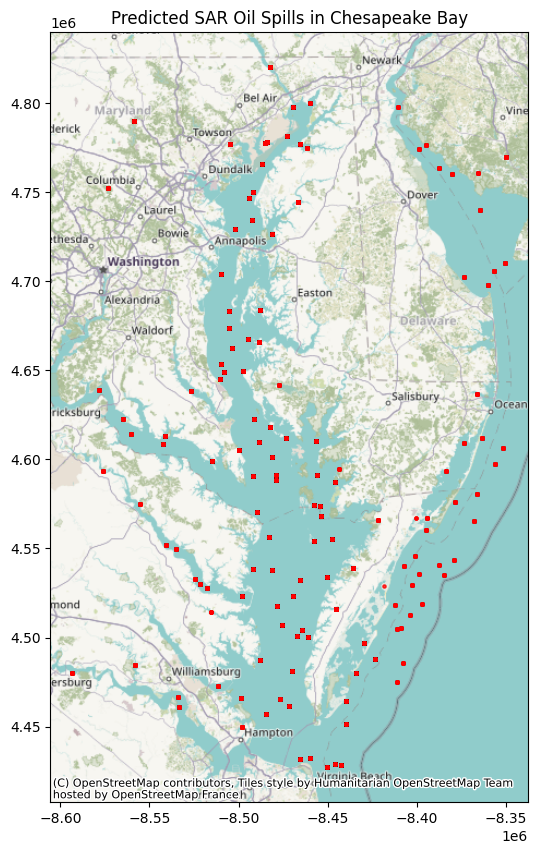

In [7]:


# Convert to Web Mercator for basemap plotting
gdf = gdf.to_crs(epsg=3857)

# Plot
ax = gdf.plot(figsize=(10,10), color='red', markersize=5, alpha=0.5)
ctx.add_basemap(ax)
plt.title("Predicted SAR Oil Spills in Chesapeake Bay")
plt.show()

In [20]:
#---RANDOM FOREST ML MODEL---#

#strong backscatter (dark VV Values) means it's a more severe spill. To predict this severity, we gotta define what severity means.

#Defining what that severity means:
chesapeake_df['severity'] = chesapeake_df['VV'].apply(lambda x: 'High' if x < -28 else ('Medium' if x < -25 else 'Low'))

X = chesapeake_df[['VH','VH_VV_ratio', 'angle']]

y = chesapeake_df['severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)


from sklearn.utils import resample

# Combine X and y
df_balanced = pd.concat([X, y], axis=1)

# Separate by class
low = df_balanced[df_balanced.severity == 'Low']
med = df_balanced[df_balanced.severity == 'Medium']
high = df_balanced[df_balanced.severity == 'High']

# Downsample 'Low' to match the others
low_down = resample(low, replace=False, n_samples=len(med), random_state=42)

# Combine back together
df_balanced = pd.concat([low_down, med, high])

# Split again
X = df_balanced[['VH','VH_VV_ratio', 'angle']]
y = df_balanced['severity']
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/var/folders/qp/4fnpt3gj6r935q_1r78969l80000gn/T/ipykernel_78978/1397030854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chesapeake_df['severity'] = chesapeake_df['VV'].apply(lambda x: 'High' if x < -28 else ('Medium' if x < -25 else 'Low'))


              precision    recall  f1-score   support

        High       0.99      0.97      0.98       820
         Low       0.99      1.00      1.00      5264
      Medium       0.97      0.97      0.97      1284

    accuracy                           0.99      7368
   macro avg       0.98      0.98      0.98      7368
weighted avg       0.99      0.99      0.99      7368



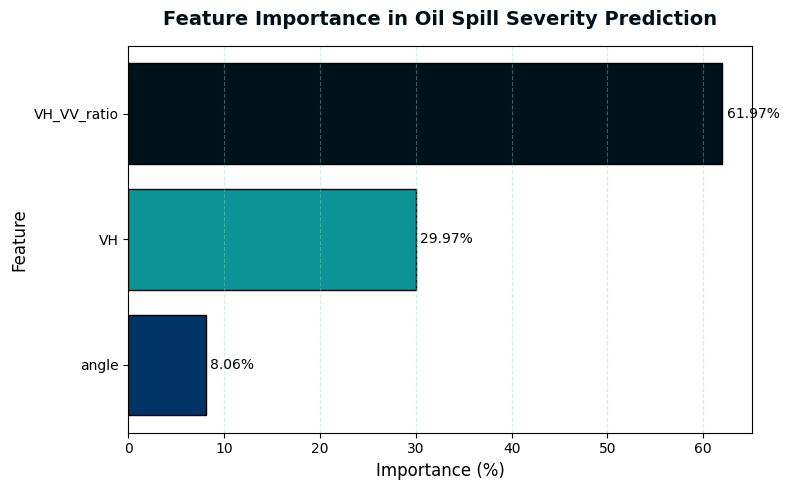

In [21]:


# --- Get feature importances from your trained Random Forest model ---
importances = model.feature_importances_
features = X.columns

# --- Create a sorted Series ---
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True) * 100  # convert to %

# --- Create a custom ocean-to-oil color palette ---
# Blue = ocean, black = oil, gradual blend
from matplotlib.colors import LinearSegmentedColormap
ocean_oil_cmap = LinearSegmentedColormap.from_list("ocean_oil", ["#003366", "#005f73", "#0a9396", "#94d2bd", "#001219"])

colors = [ocean_oil_cmap(i) for i in np.linspace(0, 1, len(feat_imp))]

# --- Plot ---
plt.figure(figsize=(8, 5))
bars = plt.barh(feat_imp.index, feat_imp.values, color=colors, edgecolor='black')

# --- Add text labels showing percentage values ---
for bar, value in zip(bars, feat_imp.values):
    plt.text(value + 0.5, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}%", va='center', fontsize=10, color='black')

# --- Titles and labels ---
plt.title('Feature Importance in Oil Spill Severity Prediction',
          fontsize=14, fontweight='bold', pad=15, color='#001219')
plt.xlabel('Importance (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# --- Grid and layout tweaks ---
plt.grid(axis='x', linestyle='--', alpha=0.4, color='#94d2bd')
plt.tight_layout()
plt.show()

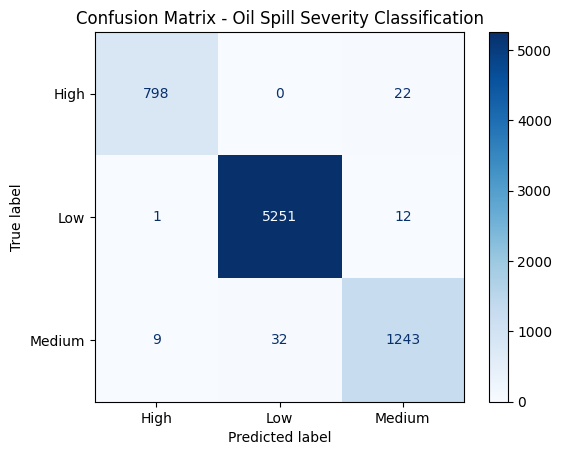

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - Oil Spill Severity Classification")
plt.show()

Epoch 1/25


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.7929 - loss: 0.5270 - val_accuracy: 0.9371 - val_loss: 0.1987
Epoch 2/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9388 - loss: 0.1791 - val_accuracy: 0.9743 - val_loss: 0.0959
Epoch 3/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.9584 - loss: 0.1215 - val_accuracy: 0.9858 - val_loss: 0.0680
Epoch 4/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9683 - loss: 0.0938 - val_accuracy: 0.9841 - val_loss: 0.0549
Epoch 5/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.9728 - loss: 0.0819 - val_accuracy: 0.9870 - val_loss: 0.0499
Epoch 6/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.9745 - loss: 0.0773 - val_accuracy: 0.9873 - val_loss: 0.0447
Epoch 7/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.9776 - loss: 0.0662 - val_accuracy: 0.9923 - val_loss: 0.0382
Epoch 8/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9801 - loss: 0.0644 - val_accurac

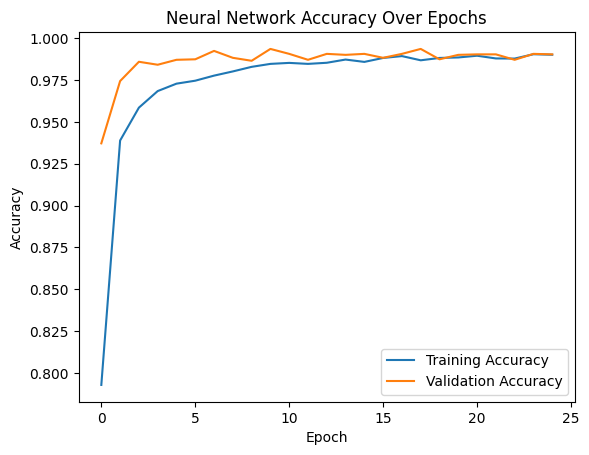

In [31]:

#----NEURAL NETWORK ML MODEL----#




X = df_balanced[['VH', 'VH_VV_ratio', 'angle']]  # no VV since it’s missing
y = df_balanced['severity']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # one-hot encode for NN
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step


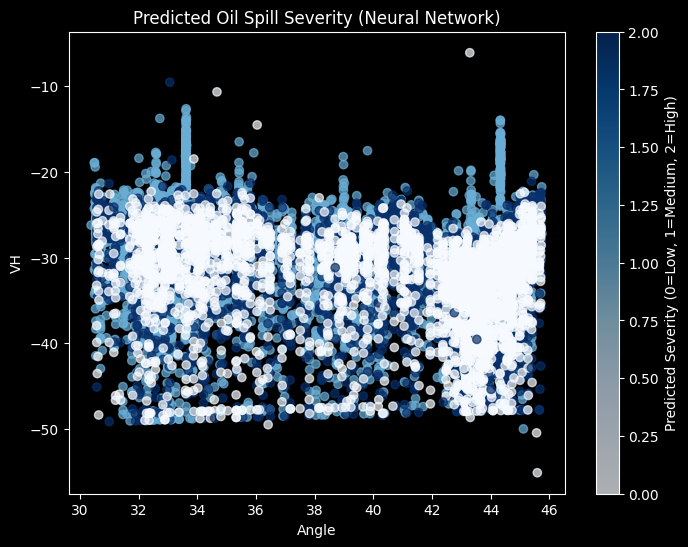

In [45]:
# Make predictions on the full (scaled) dataset
y_pred_full = model.predict(scaler.transform(X))

# Convert predictions back to readable labels
y_pred_classes = np.argmax(y_pred_full, axis=1)
df_balanced['predicted_severity'] = label_encoder.inverse_transform(y_pred_classes)

# Visualize predicted severity on a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(df_balanced['angle'], df_balanced['VH'], 
            c=y_pred_classes, cmap='Blues', alpha=0.7)
plt.colorbar(label='Predicted Severity (0=Low, 1=Medium, 2=High)')
plt.style.use('dark_background')
plt.xlabel('Angle')
plt.ylabel('VH')
plt.title('Predicted Oil Spill Severity (Neural Network)')
plt.show()

530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step


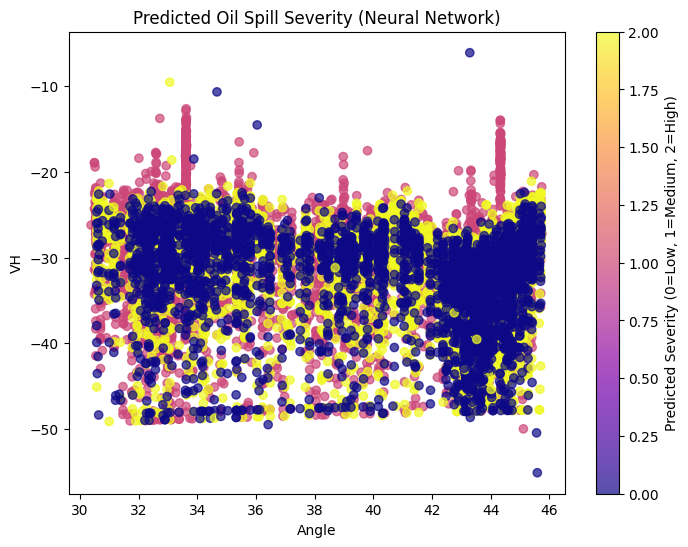

In [42]:
# Make predictions on the full (scaled) dataset
y_pred_full = model.predict(scaler.transform(X))

# Convert predictions back to readable labels
y_pred_classes = np.argmax(y_pred_full, axis=1)
df_balanced['predicted_severity'] = label_encoder.inverse_transform(y_pred_classes)

# Visualize predicted severity on a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(df_balanced['angle'], df_balanced['VH'], 
            c=y_pred_classes, cmap='plasma', alpha=0.7)
plt.colorbar(label='Predicted Severity (0=Low, 1=Medium, 2=High)')
plt.xlabel('Angle')
plt.ylabel('VH')
plt.title('Predicted Oil Spill Severity (Neural Network)')
plt.show()

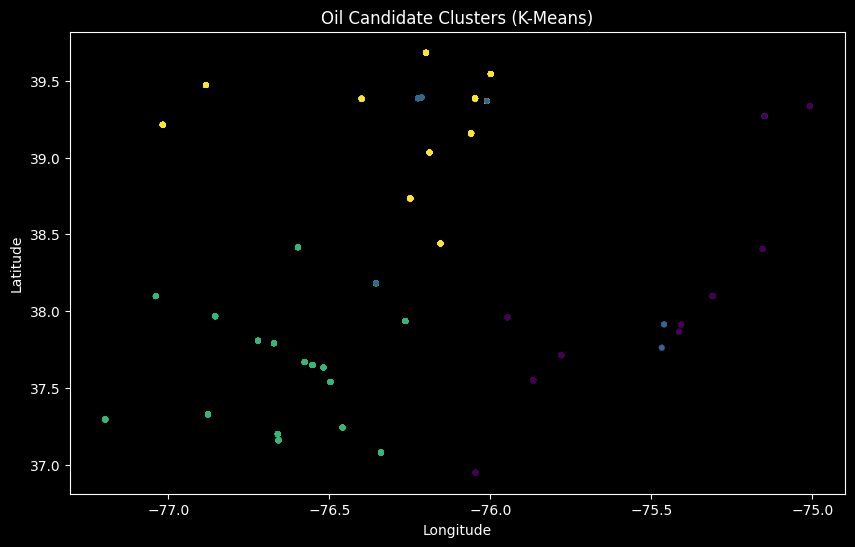

In [ ]:
# Load your dataset
df = pd.read_csv("/data/oil_points_AIS_stats_all.csv")

features = ['oil_lat', 'oil_lon', 'num_ships_near_point', 'closest_ship_distance_km', 'avg_ship_speed']


df[features] = df[features].fillna(df[features].mean())
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)

df['cluster'] = kmeans.fit_predict(X_scaled)


plt.figure(figsize=(10, 6))
plt.scatter(df['oil_lon'], df['oil_lat'], c=df['cluster'], cmap='viridis', s=10)
plt.title('Oil Candidate Clusters (K-Means)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
#---OIL SPATIAL ANALYSIS FOT PRANALI'S SCRIPT---#


# Load your data
df = pd.read_csv("/data/oil_points_AIS_stats_all.csv")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['oil_lon'], df['oil_lat']),
    crs="EPSG:4326"  # WGS84 coordinate system
)
# Convert degrees to meters (project for distance calculations)
gdf = gdf.to_crs(epsg=3857)

# Add a 5 km buffer
gdf['buffer_5km'] = gdf.geometry.buffer(5000)
gdf['Date'] = pd.to_datetime(gdf['Date'])
gdf = gdf.sort_values('Date')
results = []

for i, row in gdf.iterrows():
    date = row['Date']
    geom = row['buffer_5km']
    
    # Find oil points within 5 km on the next date
    next_date = gdf[gdf['Date'] > date].head(1)['Date']
    if len(next_date) == 0:
        continue
    next_date = next_date.iloc[0]
    next_day_points = gdf[gdf['Date'] == next_date]
    
    nearby = next_day_points[next_day_points.geometry.within(geom)]
    if not nearby.empty:
        results.append({
            'current_date': date,
            'next_date': next_date,
            'oil_reappears': True,
            'count_nearby': len(nearby)
        })

results_df = pd.DataFrame(results)


In [66]:
print(results_df['oil_reappears'].value_counts())

oil_reappears
True    1961
Name: count, dtype: int64


In [67]:
print(results_df['oil_reappears'].value_counts())

oil_reappears
True    1961
Name: count, dtype: int64


In [72]:
#---3D VISUALIZATION OF PERSISTANCE---#


# Round coordinates slightly so nearby detections group together
df['oil_lat_rounded'] = df['oil_lat'].round(2)
df['oil_lon_rounded'] = df['oil_lon'].round(2)

# Count how many times each coordinate reappears (persistence)
persistence_df = df.groupby(['oil_lat_rounded', 'oil_lon_rounded']).size().reset_index(name='persistence_count')
date_map = df.groupby(['oil_lat_rounded', 'oil_lon_rounded'])['Date'].min().reset_index()
persistence_df = persistence_df.merge(date_map, on=['oil_lat_rounded', 'oil_lon_rounded'])
persistence_df['Date'] = pd.to_datetime(persistence_df['Date'])


fig = px.scatter_3d(
    persistence_df,
    x='oil_lon_rounded',
    y='oil_lat_rounded',
    z='Date',
    color='persistence_count',
    size='persistence_count',
    color_continuous_scale='Viridis',
    title="3D Visualization of Oil Spill Persistence Over Time",
    labels={'oil_lon_rounded': 'Longitude', 'oil_lat_rounded': 'Latitude', 'Date': 'Date'}
)

fig.update_traces(marker=dict(line=dict(width=0)))
fig.show()

In [ ]:
#---SAME THING BUT ANIMATED---#


# --- LOAD YOUR DATA ---
df = pd.read_csv("/data/oil_points_AIS_stats_all.csv")

# Clean and prepare
df['Date'] = pd.to_datetime(df['Date'])
df['oil_lat_rounded'] = df['oil_lat'].round(2)
df['oil_lon_rounded'] = df['oil_lon'].round(2)

# --- COUNT PERSISTENCE (how often oil reappears near same coordinates) ---
persistence_df = (
    df.groupby(['oil_lat_rounded', 'oil_lon_rounded', 'Date'])
    .size()
    .reset_index(name='detections')
)

# --- AGGREGATE TOTAL PERSISTENCE (how many total detections per site) ---
total_persistence = (
    df.groupby(['oil_lat_rounded', 'oil_lon_rounded'])
    .size()
    .reset_index(name='persistence_count')
)

# Merge so each frame knows total persistence
persistence_df = persistence_df.merge(total_persistence, on=['oil_lat_rounded', 'oil_lon_rounded'])

# --- CREATE ANIMATED 3D SCATTER ---
fig = px.scatter_3d(
    persistence_df,
    x='oil_lon_rounded',
    y='oil_lat_rounded',
    z='persistence_count',
    color='persistence_count',  # total persistence
    animation_frame=persistence_df['Date'].dt.strftime('%Y-%m-%d'),
    size='detections',
    color_continuous_scale='Plasma',
    title="Animated 3D Visualization of Oil Spill Persistence Over Time",
    labels={
        'oil_lon_rounded': 'Longitude',
        'oil_lat_rounded': 'Latitude',
        'detections': 'Detections per Day'
    },
)

# Optional: tweak the look
fig.update_traces(marker=dict(line=dict(width=0)))
fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Detections',
))

fig.show()

